In [1]:
# please upload data directory to Google drive
# use Google Drive to load data
from google.colab import drive, files
import zipfile
drive.mount('/content/drive')

zipname = 'supports.zip'
uploaded = files.upload()
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

Mounted at /content/drive


Saving supports.zip to supports.zip


In [2]:
!pip install -r "requirements.txt"
!pip install torchinfo
!pip install torcheval
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [5]:
from sklearn.model_selection import train_test_split
from models.AST import AST
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data

In [7]:
root = '/content/drive/MyDrive/Data/genres_original' # Change according path storing data
sr = 16 * 1000
x,y,min_length = read_data(root=root, sr=sr)
print("finsh reading data")

finsh reading data


# Conversion, Compression and Normalisation

In [8]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [9]:
x = np.asarray(x)
x = x.transpose((0,2,1))
y = np.asarray(y)
print(x.shape)

(1000, 936, 128)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [11]:
batch_size = 24
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [12]:
model = AST(10,input_fdim=x.shape[2],input_tdim=x.shape[1])
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-5)
summary(model,[(batch_size,x.shape[1],x.shape[2])])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

frequncey stride=10, time stride=10
number of patches=1116


Layer (type:depth-idx)                   Output Shape              Param #
AST                                      [24, 10]                  2,398,160
├─VisionTransformerDistilled: 1-3        --                        (recursive)
│    └─ASTPatchEmbed: 2-1                [24, 1116, 768]           --
│    │    └─Conv2d: 3-1                  [24, 768, 12, 93]         197,376
│    └─Dropout: 2-2                      [24, 1118, 768]           --
├─ModuleList: 1-2                        --                        --
│    └─Block: 2-3                        [24, 1118, 768]           --
│    │    └─LayerNorm: 3-2               [24, 1118, 768]           1,536
│    │    └─Attention: 3-3               [24, 1118, 768]           2,362,368
│    │    └─Identity: 3-4                [24, 1118, 768]           --
│    │    └─Identity: 3-5                [24, 1118, 768]           --
│    │    └─LayerNorm: 3-6               [24, 1118, 768]           1,536
│    │    └─Mlp: 3-7                     [24, 1118,

# Train

In [13]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.2955078125
train set accuracy: 0.13437500596046448
valid set loss: 2.27314453125
valid set accuracy: 0.20000000298023224
fold 2:
train set loss: 2.2786865234375
train set accuracy: 0.13593749701976776
valid set loss: 2.22158203125
valid set accuracy: 0.2562499940395355
fold 3:
train set loss: 2.254296875
train set accuracy: 0.16718749701976776
valid set loss: 2.14833984375
valid set accuracy: 0.28125
fold 4:
train set loss: 2.22900390625
train set accuracy: 0.19843749701976776
valid set loss: 2.1447265625
valid set accuracy: 0.21875
fold 5:
train set loss: 2.1839111328125
train set accuracy: 0.24375000596046448
valid set loss: 2.10986328125
valid set accuracy: 0.30000001192092896
epoch loss: 2.18
epoch accuracy: 0.251
-------epoch  2 -------
fold 1:
train set loss: 2.15654296875
train set accuracy: 0.2890625
valid set loss: 2.09169921875
valid set accuracy: 0.3687500059604645
fold 2:
train set loss: 2.1402099609375
train set accuracy: 0

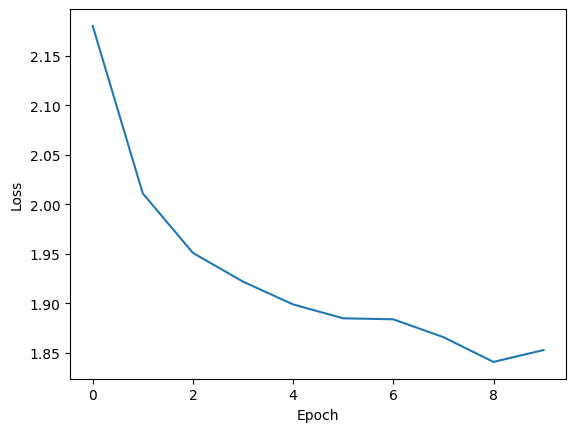

In [14]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

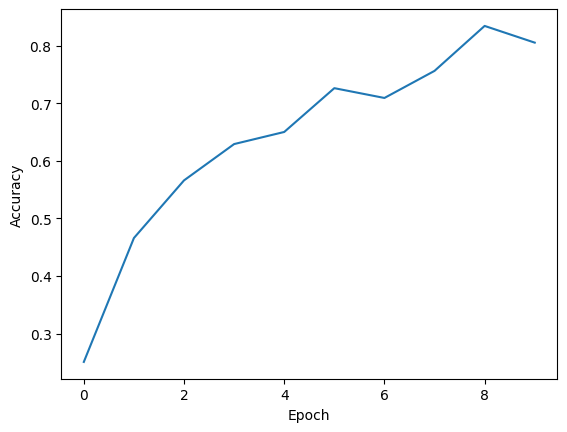

In [15]:
plt.show()
##%%
plt.plot(range(epoch),history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [16]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.91
test set accuracy: 0.74
test set AUC: 0.928
test set f1-score: 0.74
